# <p><center style="font-family:newtimeroman;font-size:180%;">Image Colorization Using Auto Encoder </center></p>
### Table of contents:

* [Import Libraries](#1)
* [Read Data](#2)
* [Visualization Of Dataset](#3)
* [Train Auto Encoder Model](#5)
* [Evaluate The Model](#6)

**<a id="1"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Import Libraries </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from skimage.color import rgb2lab,lab2rgb
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**<a id="2"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Read Data </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [2]:
def load_data(path):
    Input,Output,images=[],[],[]
    for i in tqdm(os.listdir(path)):
        path_=os.path.join(path,i)
        image=load_img(path_,target_size=(256,256),color_mode='rgb')
        image=img_to_array(image)
        image=image/255.0
        lab=rgb2lab(image)
        Input.append(lab[:,:,0])
        Output.append(lab[:,:,1:]/128)
    return np.array(Input),np.array(Output)

In [3]:
Input,Output=load_data('/kaggle/input/image-colorization-dataset/data/train_color')

100%|██████████| 5000/5000 [01:19<00:00, 63.28it/s]


In [4]:
print('Input shape is ' , Input.shape)
print('Output shape is ' , Output.shape)

Input shape is  (5000, 256, 256)
Output shape is  (5000, 256, 256, 2)


In [5]:
Input=np.expand_dims(Input,axis=-1)
print('Input shape is ' , Input.shape)
print('Output shape is ' , Output.shape)

Input shape is  (5000, 256, 256, 1)
Output shape is  (5000, 256, 256, 2)


**<a id="3"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Visualization of Dataset </p>
<a class="btn" href="#home">Tabel of Contents</a>

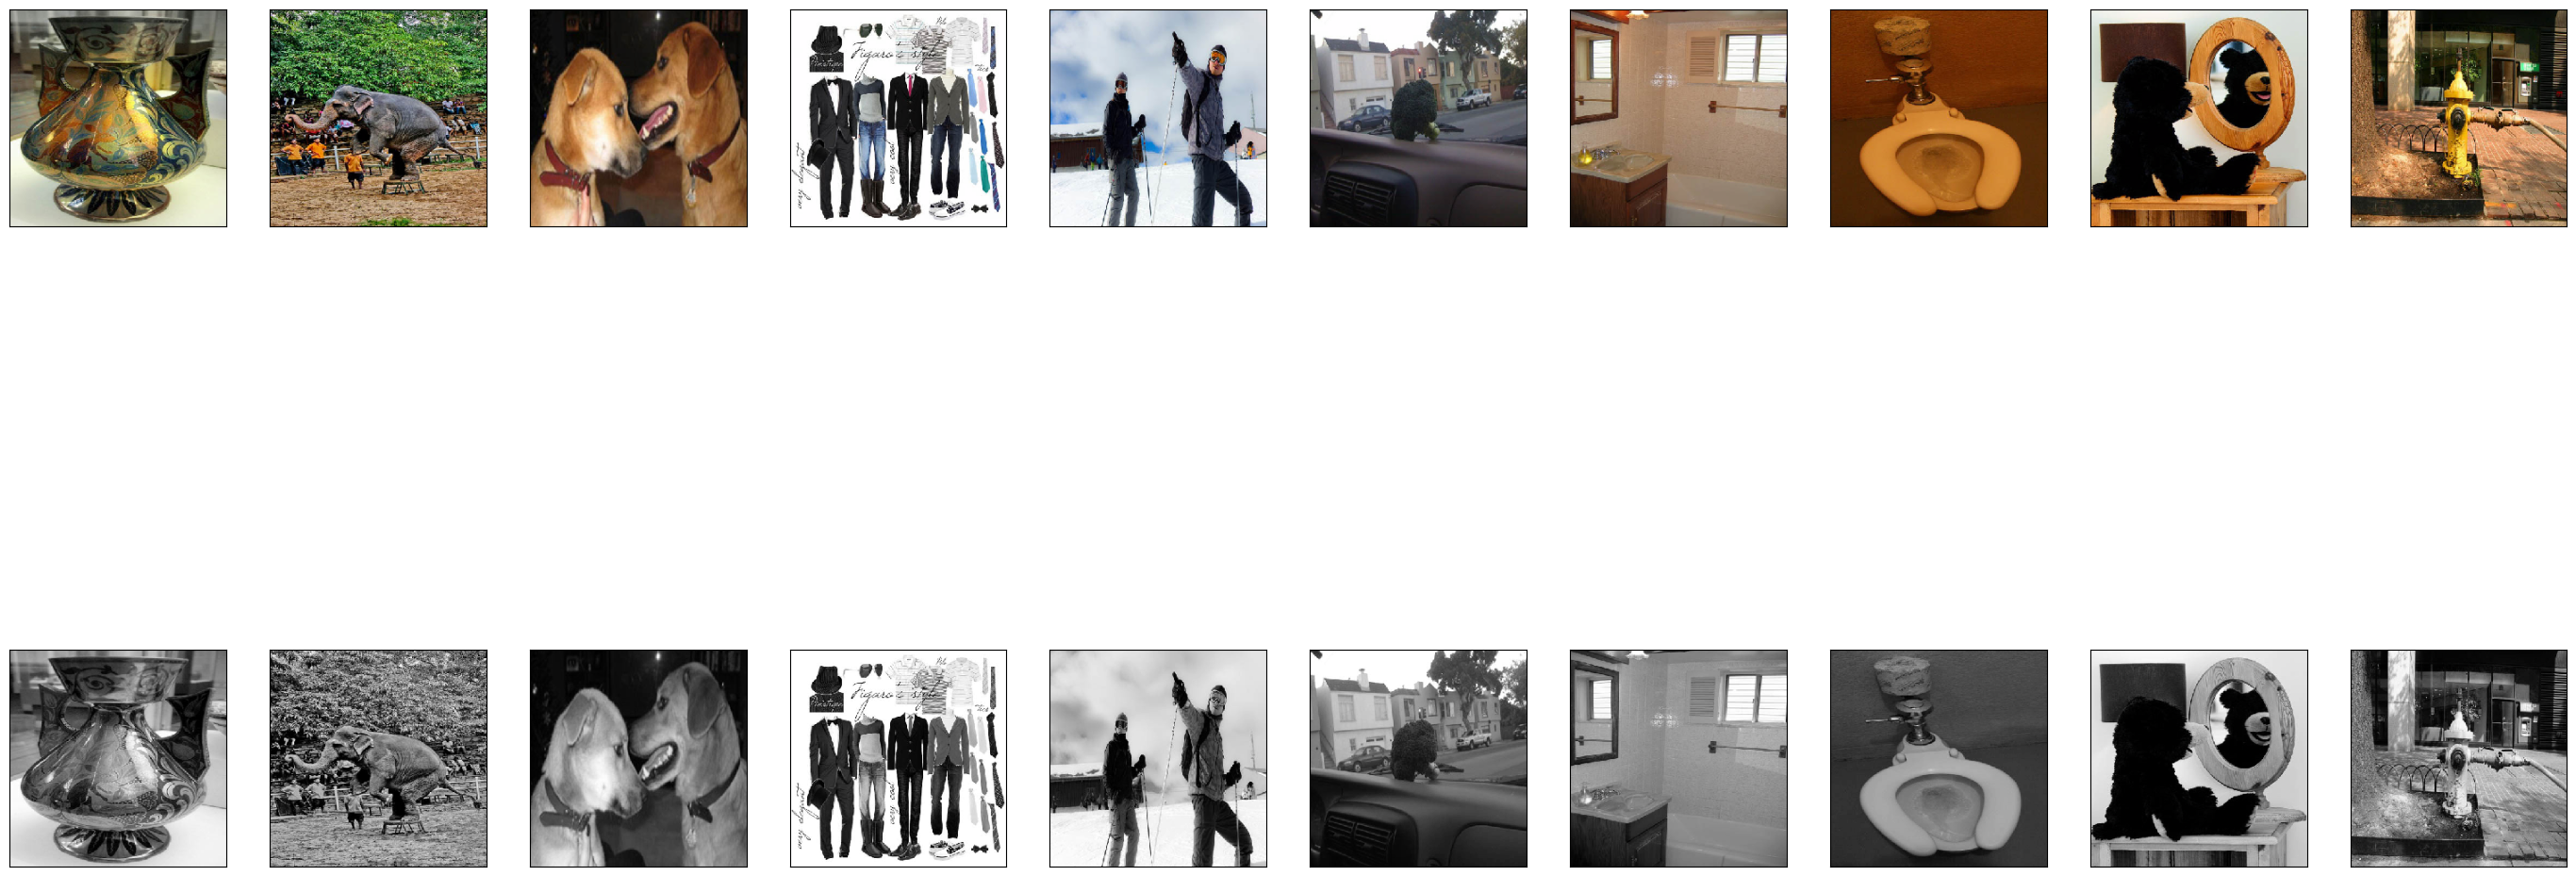

In [6]:
n=10
plt.figure(figsize=(35,25))
for i in range(n):
    # Display color images
    ax = plt.subplot(3, n, i + 1 + n)
    image=np.zeros((256,256,3))
    image[:,:,0]=Input[i][:,:,0]
    image[:,:,1:]=Output[i]*128
    plt.imshow(lab2rgb(image))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display black images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(Input[i],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

<a id="5"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Modeling </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [7]:
X_train, X_test, y_train, y_test = train_test_split(Input,Output, test_size=0.2, random_state=44, shuffle =True)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (4000, 256, 256, 1)
X_test shape is  (1000, 256, 256, 1)
y_train shape is  (4000, 256, 256, 2)
y_test shape is  (1000, 256, 256, 2)


In [8]:
# Input layer with shape (200, 200, 1)
input_ = keras.layers.Input(shape=(256,256,1))
# Encoder
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu',strides=2)(input_)
x = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu',strides=2)(x)
x = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu',strides=2)(x)
x = keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
encoder = keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)

# Decoder
x = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(encoder)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
# Adjust the output layer for an RGB image (2 channels)
x = keras.layers.Conv2D(2, (3, 3), padding='same', activation=keras.layers.LeakyReLU(alpha=.5))(x)
decoder = keras.layers.UpSampling2D((2, 2))(x)
# Autoencoder model
autoencoder = keras.models.Model(inputs=input_, outputs=decoder)
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 512)       118016

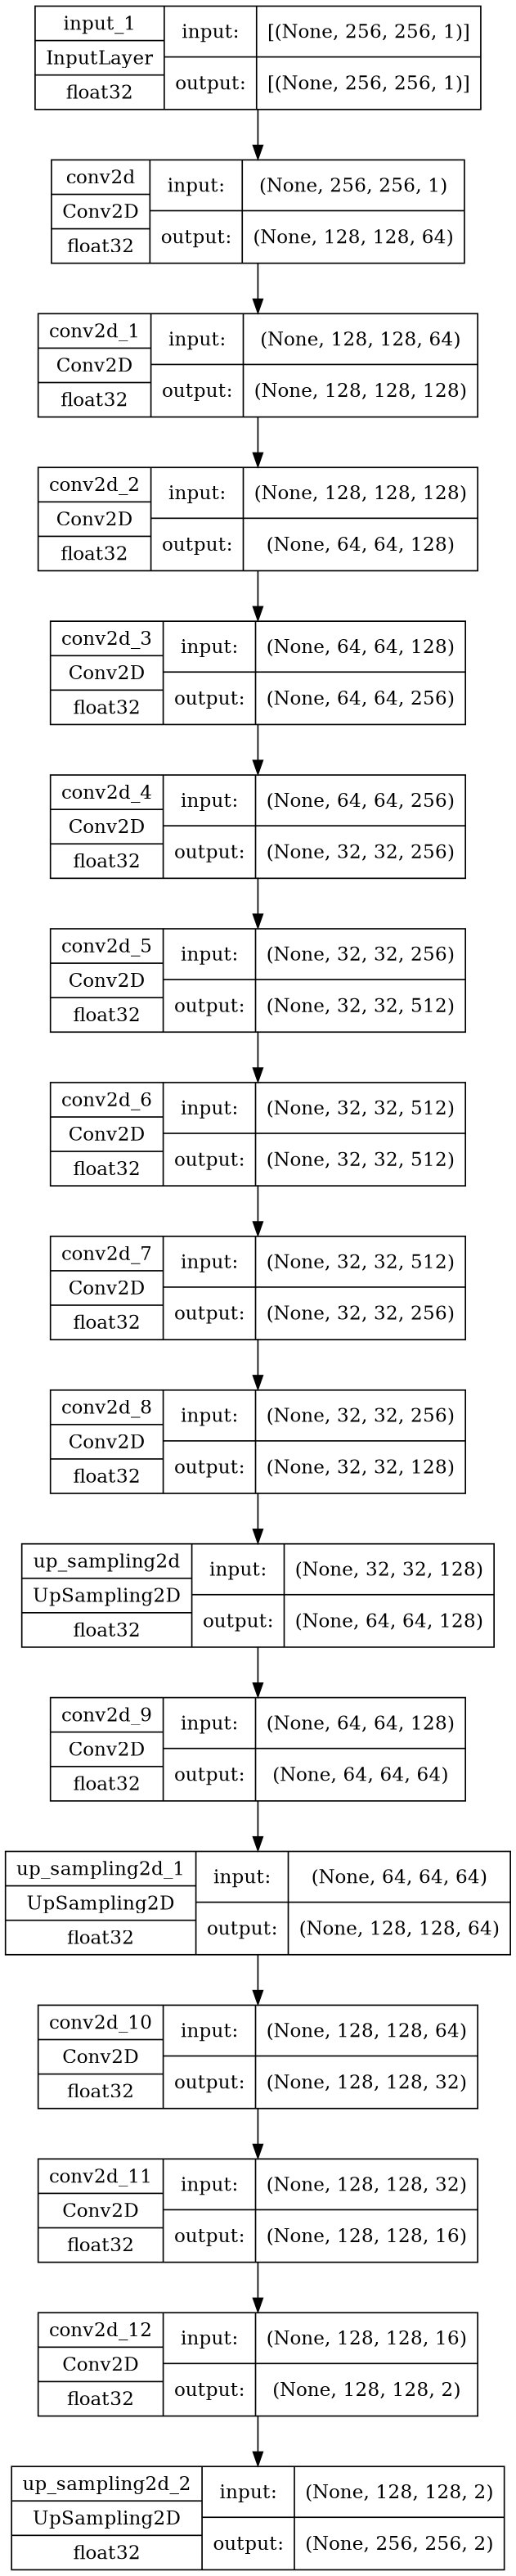

In [9]:
tf.keras.utils.plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [10]:
checkpoint_cb =ModelCheckpoint("autoencoder.h5",save_best_only=True)
autoencoder.compile(optimizer ='adam', loss='mse')
hist=autoencoder.fit(X_train,y_train,epochs=100,validation_split=.1,callbacks=[checkpoint_cb])

Epoch 1/100
113/113 [==============================] - 68s 353ms/step - loss: 0.1435 - val_loss: 0.0140
Epoch 2/100


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/113 [==============================] - 33s 295ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 3/100
113/113 [==============================] - 34s 302ms/step - loss: 0.0131 - val_loss: 0.0145
Epoch 4/100
113/113 [==============================] - 34s 302ms/step - loss: 0.0131 - val_loss: 0.0133
Epoch 5/100
113/113 [==============================] - 34s 300ms/step - loss: 0.0130 - val_loss: 0.0133
Epoch 6/100
113/113 [==============================] - 34s 305ms/step - loss: 0.0130 - val_loss: 0.0133
Epoch 7/100
113/113 [==============================] - 34s 301ms/step - loss: 0.0131 - val_loss: 0.0132
Epoch 8/100
113/113 [==============================] - 34s 301ms/step - loss: 0.0130 - val_loss: 0.0132
Epoch 9/100
113/113 [==============================] - 34s 301ms/step - loss: 0.0130 - val_loss: 0.0131
Epoch 10/100
113/113 [==============================] - 34s 298ms/step - loss: 0.0131 - val_loss: 0.0132
Epoch 11/100
113/113 [==============================] - 33s 296ms/step - lo

<a id="6"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Evaluate The Model  </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [11]:
hist_=pd.DataFrame(hist.history)
hist_

loss  val_loss
0   0.143473  0.014006
1   0.013387  0.013408
2   0.013145  0.014498
3   0.013090  0.013281
4   0.013047  0.013276
..       ...       ...
95  0.003165  0.013494
96  0.003105  0.013516
97  0.003030  0.013676
98  0.003010  0.013916
99  0.003000  0.013708

[100 rows x 2 columns]

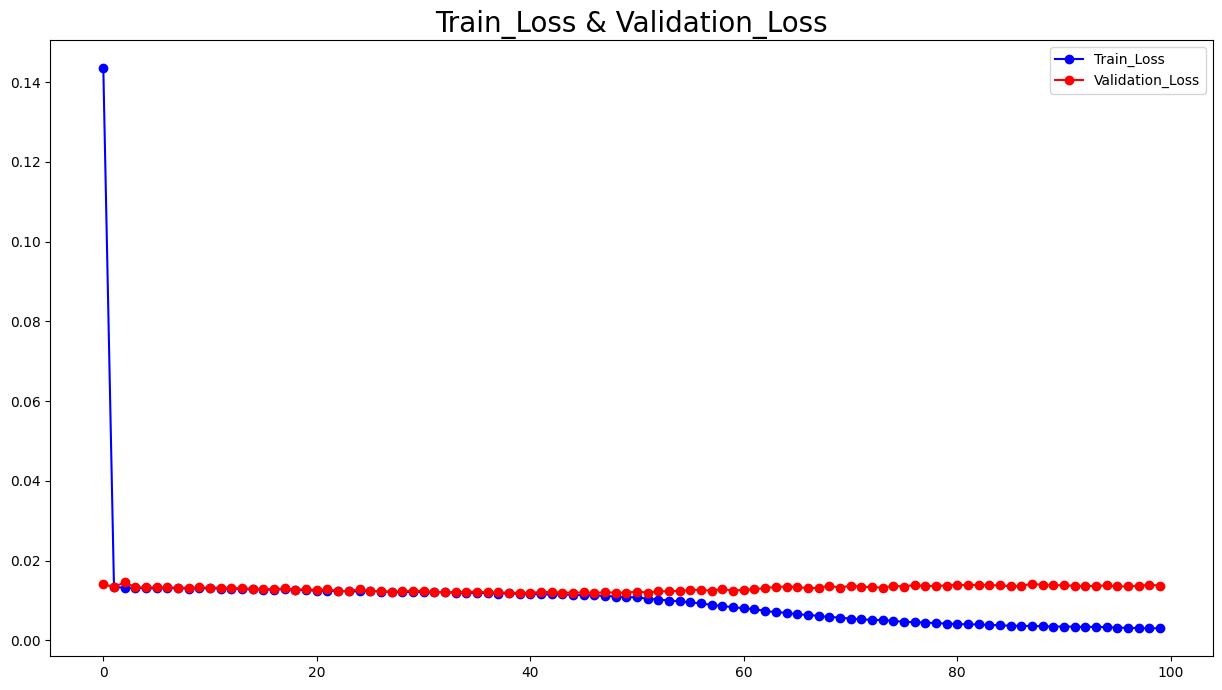

In [12]:
plt.figure(figsize=(15,8))
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.show()

In [13]:
autoencoder.evaluate(X_test,y_test)

32/32 [==============================] - 4s 128ms/step - loss: 0.0129


0.012939495034515858

In [14]:
predictions = autoencoder.predict(X_test)
predictions.shape

32/32 [==============================] - 3s 84ms/step


(1000, 256, 256, 2)

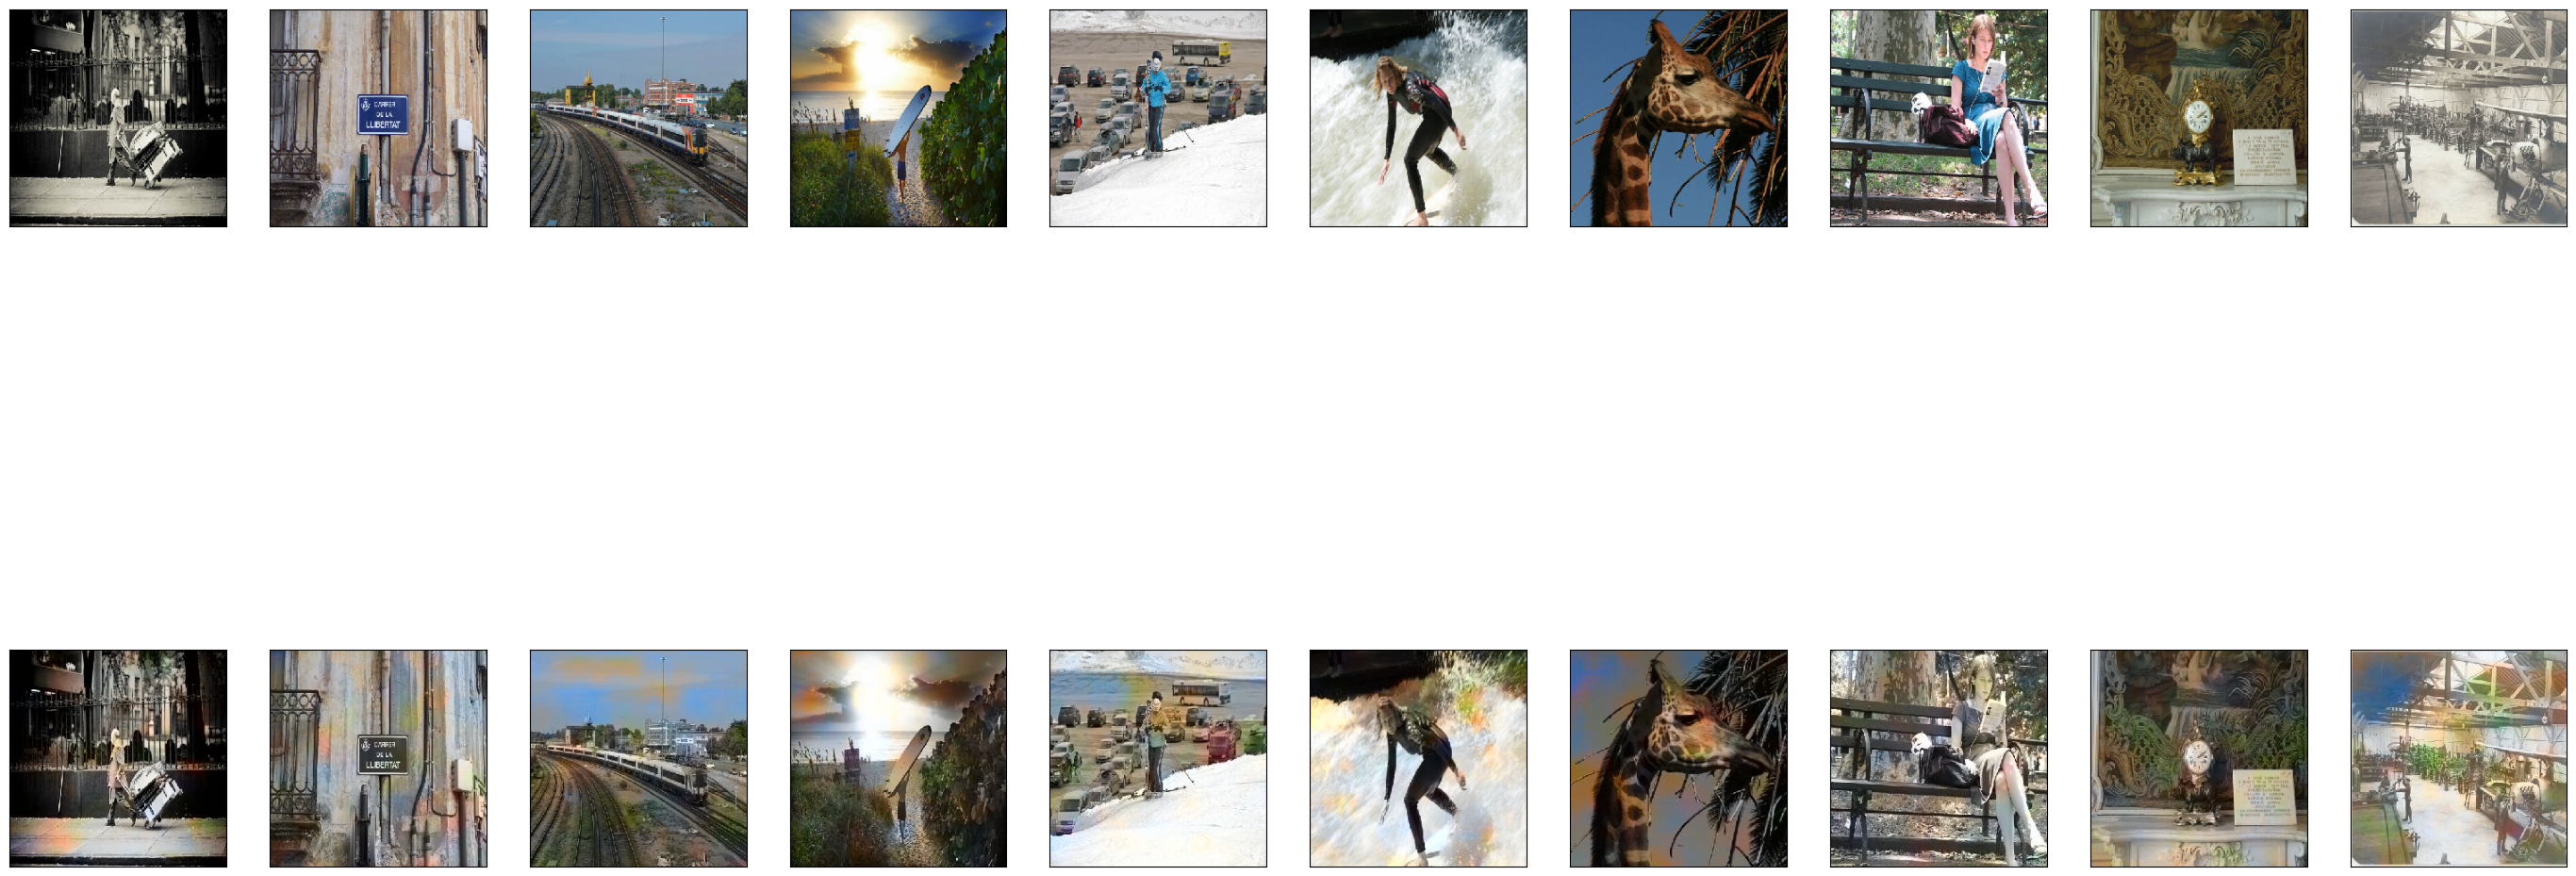

In [15]:
n = 10
plt.figure(figsize=(35, 25))
for i in range(n):
    # Display original gray images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display original color images
    ax = plt.subplot(3, n, i + 1)
    image = np.zeros((256, 256, 3))
    image[:, :, 0] = X_test[i][:,:,0]
    image[:, :, 1:] = y_test[i]* 128
    plt.imshow(lab2rgb(image))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display pred images
    ax = plt.subplot(3, n, i + 1 + n)
    image[:, :, 0] = X_test[i][:,:,0]
    image[:, :, 1:] = predictions[i]* 128
    plt.imshow(lab2rgb(image))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [16]:
psnr_values=[abs(peak_signal_noise_ratio(color,pred,data_range=color.max()-pred.min())) 
             for color,pred in zip(y_test,predictions)]
print('Average PSNR =',np.mean(psnr_values))

Average PSNR = 15.969455084952036
